In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from fgspectra import cross as fgc
from fgspectra import power as fgp
from fgspectra import frequency as fgf
import numpy as np
import matplotlib.pyplot as plt

## ACT Parameters

This notebook implements the models in [Dunkley et al. 2013](https://arxiv.org/abs/1301.0776).
We write down the ACT parameters (these are from the multifrequency likelihood).

In [3]:
par = {
    "nu_0": 150.0,
    "ell_0": 3000,
    "T_CMB": 2.725,
    "T_d": 9.7,
    "a_tSZ": 4.66,
    "a_kSZ": 1.60,
    "a_p": 6.87,
    "beta_p": 2.08,
    "a_c": 6.10,
    "beta_c": 2.08,
    "n_CIBC": 1.20,
    "xi": 0.09,
    "a_s": 3.50,
    "a_g": 0.88,
}

## Models

In [6]:
# define the models from fgspectra
ksz = fgc.FactorizedCrossSpectrum(fgf.ConstantSED(), fgp.kSZ_bat())
cibp = fgc.FactorizedCrossSpectrum(fgf.ModifiedBlackBody(), fgp.PowerLaw())
radio = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())
cirrus = fgc.FactorizedCrossSpectrum(fgf.PowerLaw(), fgp.PowerLaw())

# if there are correlations between components,
# have to define them in a joined spectrum
tSZ_and_CIB = fgc.CorrelatedFactorizedCrossSpectrum(
    fgf.Join(fgf.ThermalSZ(), fgf.CIB()), fgp.SZxCIB_Addison2012()
)

# for testing purposes we'll also compute the tSZ and clustered CIB alone
tsz = fgc.FactorizedCrossSpectrum(fgf.ThermalSZ(), fgp.tSZ_150_bat())
cibc = fgc.FactorizedCrossSpectrum(fgf.CIB(), fgp.PowerLaw())

## Calling the Models

We can call the models individually.

In [7]:
freqs = np.array([150.0])
ells = np.arange(2, 3000)

In [8]:
par["a_s"] * radio(
    {"nu": freqs, "beta": -0.5 + 2, "nu_0": par["nu_0"]},
    {"ell": ells, "alpha": 2, "ell_0": par["ell_0"]},
)

array([[[1.55555556e-06, 3.50000000e-06, 6.22222222e-06, ...,
         3.49300350e+00, 3.49533489e+00, 3.49766706e+00]]])

## All The Models

To make a combined model, usually you should wrap `fgspectra` in your own function call and pass in whatever dictionary elements you want, so you can name your parameters.

In [24]:
def get_fg_model(freqs, ells, par):
    return (
        par["a_kSZ"] * ksz({"nu": freqs}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_p"]
        * cibp(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_p"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        # joint tSZ, CIB, and their correlation
        tSZ_and_CIB(
            {
                "kwseq": (
                    {"nu": freqs, "nu_0": par["nu_0"]},
                    {
                        "nu": freqs,
                        "nu_0": par["nu_0"],
                        "temp": par["T_d"],
                        "beta": par["beta_c"],
                    },
                )
            },
            {
                "kwseq": (
                    {"ell": ells, "ell_0": par["ell_0"], "amp": par["a_tSZ"]},
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "alpha": 2 - par["n_CIBC"],
                        "amp": par["a_c"],
                    },
                    {
                        "ell": ells,
                        "ell_0": par["ell_0"],
                        "amp": -par["xi"] * np.sqrt(par["a_tSZ"] * par["a_c"]),
                    },
                )
            },
        ),
        par["a_s"]
        * radio(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": -0.5 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2},
        ),
        par["a_g"]
        * cirrus(
            {"nu": freqs, "nu_0": par["nu_0"], "beta": 3.8 - 2},
            {"ell": ells, "ell_0": par["ell_0"], "alpha": -0.7},
        ),
        # THESE TWO ARE REDUDUNDANT, BUT USEFUL FOR TESTING
        par["a_tSZ"]
        * tsz({"nu": freqs, "nu_0": par["nu_0"]}, {"ell": ells, "ell_0": par["ell_0"]}),
        par["a_c"]
        * cibc(
            {
                "nu": freqs,
                "nu_0": par["nu_0"],
                "temp": par["T_d"],
                "beta": par["beta_c"],
            },
            {"ell": ells, "ell_0": par["ell_0"], "alpha": 2 - par["n_CIBC"]},
        ),
    )

In [25]:
specs = get_fg_model(freqs, ells, par)

In [26]:
# remove the last tSZ, CIBC since they are redundant
specs = specs[:-2]

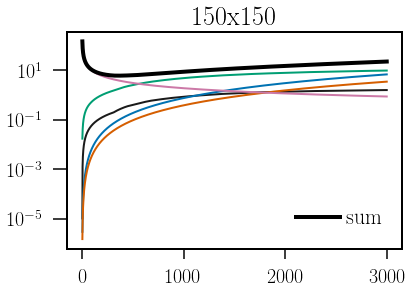

In [27]:
for spec in specs:
    plt.plot(ells, spec[0, 0], lw=2)

plt.plot(ells, np.sum([s[0, 0] for s in specs], axis=0), "k-", lw=4, label="sum")
plt.legend()
plt.title("150x150")
plt.yscale("log")